# Extracting and Loading the Dataset

In [18]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Path to the ZIP file
zip_path = "diabetes+130-us+hospitals+for+years+1999-2008.zip"
extract_path = "diabetes_dataset"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the extracted files
print("Extracted files:", os.listdir(extract_path))

# Path to the main dataset
data_path = "diabetes_dataset/diabetic_data.csv"

# Load the dataset
data = pd.read_csv(data_path)

# Display basic information and the first few rows
print(data.info())
print(data.head())

Extracted files: ['diabetic_data.csv', 'IDS_mapping.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  n

# Data Cleaning and Handling Missing Values

In [19]:
# Replace '?' with NaN and handle missing data
data.replace('?', pd.NA, inplace=True)

# Fill missing values in specific columns
data['weight'] = data['weight'].fillna('Unknown')
data['max_glu_serum'] = data['max_glu_serum'].fillna('None')
data['A1Cresult'] = data['A1Cresult'].fillna('None')

# Print updated information about the dataset
print("\nUpdated DataFrame Info:")
print(data.info())


Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 n

### Handle Remaining Missing Values

In [20]:
## Drop unnecessary columns and fill missing values in diagnosis columns
columns_to_drop = ['payer_code', 'medical_specialty']
existing_columns_to_drop = [col for col in columns_to_drop if col in data.columns]
if existing_columns_to_drop:
    data = data.drop(columns=existing_columns_to_drop, axis=1)
    print(f"Dropped columns: {existing_columns_to_drop}")
else:
    print(f"Columns already dropped or do not exist: {columns_to_drop}")

# Impute missing values in 'diag_1', 'diag_2', and 'diag_3' with their mode
for col in ['diag_1', 'diag_2', 'diag_3']:
    if col in data.columns:  # Ensure column exists
        mode_value = data[col].mode()[0]
        data[col] = data[col].fillna(mode_value)
        print(f"Filled missing values in {col} with mode: {mode_value}")
    else:
        print(f"Column {col} not found in DataFrame")

Dropped columns: ['payer_code', 'medical_specialty']
Filled missing values in diag_1 with mode: 428
Filled missing values in diag_2 with mode: 276
Filled missing values in diag_3 with mode: 250


# Target Variable Transformation

readmitted
0    90409
1    11357
Name: count, dtype: int64


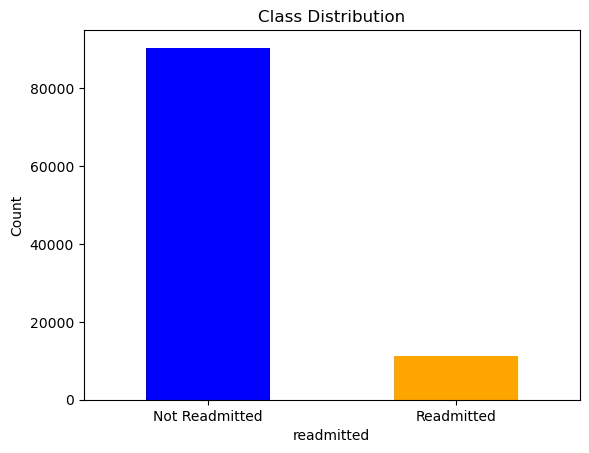

In [21]:
# Convert Target Variable 'readmitted' to Binary
data['readmitted'] = data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
print(data['readmitted'].value_counts())  # Verify target conversion

# Plot Class Distribution of Target Variable
data['readmitted'].value_counts().plot(kind='bar', title='Class Distribution', color=['blue', 'orange'])
plt.xticks(ticks=[0, 1], labels=['Not Readmitted', 'Readmitted'], rotation=0)
plt.ylabel('Count')
plt.show()

# Handling Missing Values for Categorical Columns

In [22]:
def handle_missing_values(df, columns, fill_value='Unknown'):
    for col in columns:
        df[col] = df[col].fillna(df[col].mode()[0] if fill_value == 'Unknown' else fill_value)
    return df

# Encoding Categorical Columns

In [23]:
def encode_categorical_columns(df):
    # Encode gender: Female -> 0, Male -> 1, Unknown -> NaN (or another code)
    gender_mapping = {'Female': 0, 'Male': 1, 'Unknown/Invalid': np.nan}
    df['gender'] = df['gender'].replace(gender_mapping)
    
    # Encode race with a dictionary
    race_mapping = {
        'Caucasian': 0, 'AfricanAmerican': 1, 'Asian': 2, 'Hispanic': 3, 
        'Other': 4, 'Unknown': 5
    }
    df['race'] = df['race'].replace(race_mapping)
    
    # Encode age groups by mid-point of each range
    age_mapping = {
        '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
        '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
        '[80-90)': 85, '[90-100)': 95
    }
    df['age'] = df['age'].replace(age_mapping)
    
    # Encode weight categories with a mapping
    weight_mapping = {
        'Unknown': 0, '[75-100)': 1, '[50-75)': 2, '[100-125)': 3, 
        '[125-150)': 4, '[25-50)': 5, '[0-25)': 6, '[150-175)': 7, 
        '[175-200)': 8, '>200': 9
    }
    df['weight'] = df['weight'].replace(weight_mapping).astype(int)
    
    # Encode max_glu_serum and A1Cresult as numbers
    glu_mapping = {'None': 0, 'Norm': 1, '>200': 2, '>300': 3}
    a1c_mapping = {'None': 0, 'Norm': 1, '>7': 2, '>8': 3}
    df['max_glu_serum'] = df['max_glu_serum'].replace(glu_mapping).astype(int)
    df['A1Cresult'] = df['A1Cresult'].replace(a1c_mapping).astype(int)
    
    return df

# Data Verification and Visualizations

In [24]:
# Apply missing value handling
categorical_columns = ['race', 'gender', 'age', 'weight', 'max_glu_serum', 'A1Cresult']
data = handle_missing_values(data, categorical_columns)

# Apply encoding to the categorical columns
data = encode_categorical_columns(data)

# Verify the data after processing
print("\nUnique values in 'race' after encoding:")
print(data['race'].unique())

print("\nUnique values in 'gender' after encoding:")
print(data['gender'].unique())

print("\nUnique values in 'age' after encoding:")
print(data['age'].unique())

print("\nUnique values in 'weight' after encoding:")
print(data['weight'].unique())

/tmp/ipykernel_913/493091671.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace(gender_mapping)
/tmp/ipykernel_913/493091671.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['race'] = df['race'].replace(race_mapping)
/tmp/ipykernel_913/493091671.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('f


Unique values in 'race' after encoding:
[0 1 4 2 3]

Unique values in 'gender' after encoding:
[ 0.  1. nan]

Unique values in 'age' after encoding:
[ 5 15 25 35 45 55 65 75 85 95]

Unique values in 'weight' after encoding:
[0 1 2 6 3 5 4 8 7 9]


/tmp/ipykernel_913/493091671.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['weight'] = df['weight'].replace(weight_mapping).astype(int)
/tmp/ipykernel_913/493091671.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['max_glu_serum'] = df['max_glu_serum'].replace(glu_mapping).astype(int)
/tmp/ipykernel_913/493091671.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to 

# Check for Inconsistencies and Plot Distributions


Value counts for gender:
Female: 54708
Male: 47055

Value counts for race:
Caucasian: 78372
AfricanAmerican: 19210
Hispanic: 2037
Other: 1506
Asian: 641

Value counts for age:
[70-80): 26068
[60-70): 22483
[50-60): 17256
[80-90): 17197
[40-50): 9685
[30-40): 3775
[90-100): 2793
[20-30): 1657
[10-20): 691
[0-10): 161

Value counts for weight:
Unknown: 98569
[75-100): 1336
[50-75): 897
[100-125): 625
[125-150): 145
[25-50): 97
[0-25): 48
[150-175): 35
[175-200): 11
>200: 3

Value counts for max_glu_serum:
None: 96420
Norm: 2597
>200: 1485
>300: 1264

Value counts for A1Cresult:
None: 84748
>8: 8216
Norm: 4990
>7: 3812


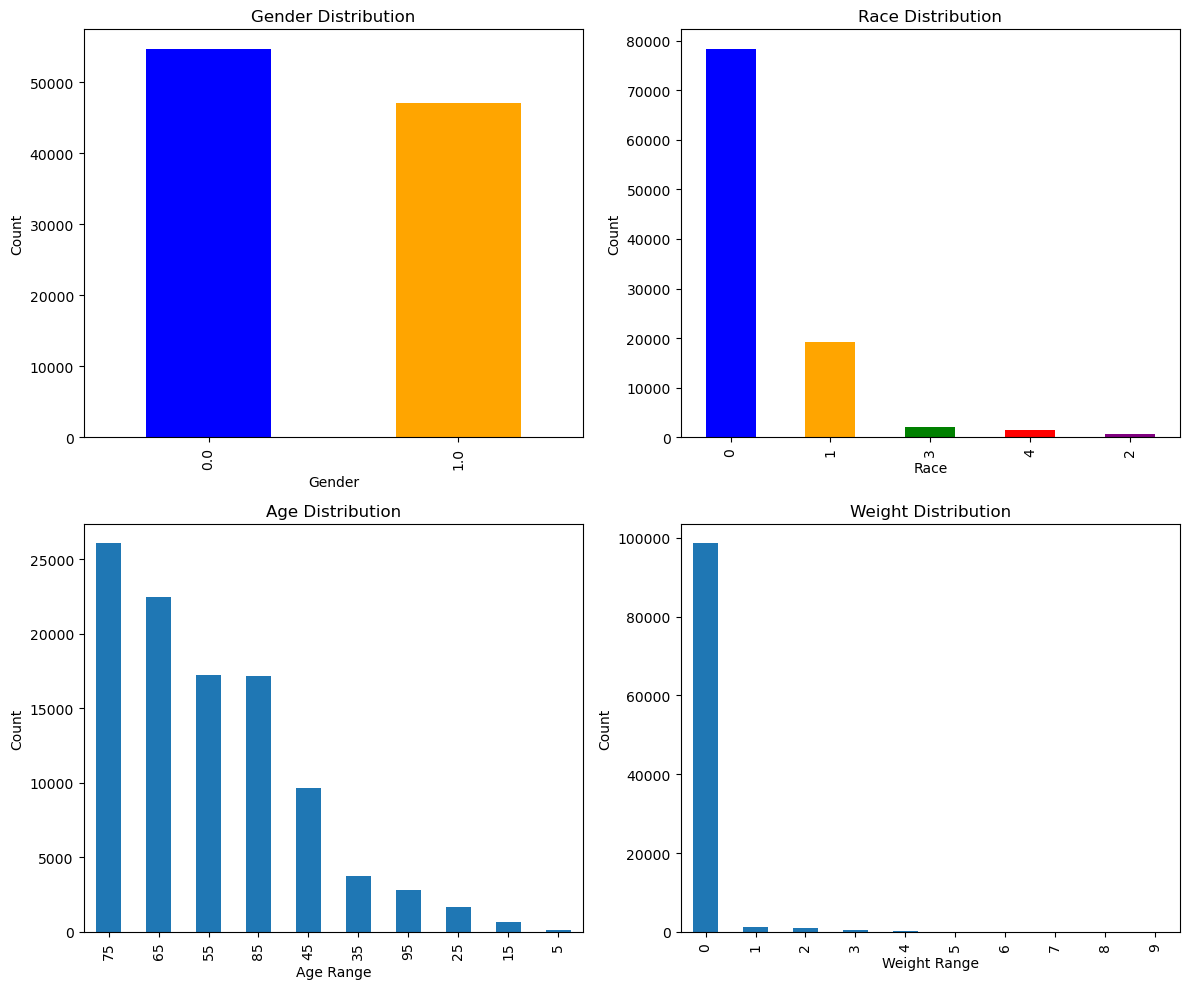

In [27]:
# Create a mapping for the original values in each column (if needed)
gender_mapping = {0: 'Female', 1: 'Male', np.nan: 'Unknown'}
race_mapping = {0: 'Caucasian', 1: 'AfricanAmerican', 2: 'Asian', 3: 'Hispanic', 4: 'Other', 5: 'Unknown'}
age_mapping = {5: '[0-10)', 15: '[10-20)', 25: '[20-30)', 35: '[30-40)', 45: '[40-50)', 55: '[50-60)', 
               65: '[60-70)', 75: '[70-80)', 85: '[80-90)', 95: '[90-100)'}
weight_mapping = {0: 'Unknown', 1: '[75-100)', 2: '[50-75)', 3: '[100-125)', 4: '[125-150)', 5: '[25-50)',
                  6: '[0-25)', 7: '[150-175)', 8: '[175-200)', 9: '>200'}
max_glu_serum_mapping = {0: 'None', 1: 'Norm', 2: '>200', 3: '>300'}
a1c_result_mapping = {0: 'None', 1: 'Norm', 2: '>7', 3: '>8'}

# Check if there are any inconsistencies in the categorical columns with original labels
categorical_columns = ['gender', 'race', 'age', 'weight', 'max_glu_serum', 'A1Cresult']
for col, mapping in zip(categorical_columns, 
                        [gender_mapping, race_mapping, age_mapping, weight_mapping, max_glu_serum_mapping, a1c_result_mapping]):
    print(f"\nValue counts for {col}:")
    value_counts = data[col].value_counts()
    
    # Display original labels with counts
    for encoded_val, count in value_counts.items():
        print(f"{mapping.get(encoded_val, encoded_val)}: {count}")

# Plot the distributions of categorical columns with original labels
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gender distribution
data['gender'].value_counts().plot(kind='bar', title="Gender Distribution", ax=axs[0, 0], color=['blue', 'orange'])
axs[0, 0].set_xlabel('Gender')
axs[0, 0].set_ylabel('Count')

# Race distribution
data['race'].value_counts().plot(kind='bar', title="Race Distribution", ax=axs[0, 1], color=['blue', 'orange', 'green', 'red', 'purple', 'yellow'])
axs[0, 1].set_xlabel('Race')
axs[0, 1].set_ylabel('Count')

# Age distribution
data['age'].value_counts().plot(kind='bar', title="Age Distribution", ax=axs[1, 0])
axs[1, 0].set_xlabel('Age Range')
axs[1, 0].set_ylabel('Count')

# Weight distribution
data['weight'].value_counts().plot(kind='bar', title="Weight Distribution", ax=axs[1, 1])
axs[1, 1].set_xlabel('Weight Range')
axs[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [28]:
# Verify the final data types and check for missing values
print("\nData types after final encoding:")
print(data.dtypes)

# Verify if there are any missing values left
print("\nMissing values per column:")
print(data.isnull().sum())


Data types after final encoding:
encounter_id                  int64
patient_nbr                   int64
race                          int64
gender                      float64
age                           int64
weight                        int64
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses              int64
max_glu_serum                 int64
A1Cresult                     int64
metformin                    object
repaglinide                  object
nateglinide                  object
chlorpropamide               object
glimepiride                  o

In [29]:
medication_columns = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]
for med_col in medication_columns:
    data[med_col] = data[med_col].map({'Yes': 1, 'No': 0}).fillna(0)

In [30]:
# Verify the final data types and check for missing values
print("\nData types after final encoding:")
print(data.dtypes)

# Verify if there are any missing values left
print("\nMissing values per column:")
print(data.isnull().sum())


Data types after final encoding:
encounter_id                  int64
patient_nbr                   int64
race                          int64
gender                      float64
age                           int64
weight                        int64
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses              int64
max_glu_serum                 int64
A1Cresult                     int64
metformin                   float64
repaglinide                 float64
nateglinide                 float64
chlorpropamide              float64
glimepiride                 fl

In [31]:
# Replace missing values with the most frequent gender (0 or 1)
most_frequent_gender = data['gender'].mode()[0]  # Get the most frequent gender
data['gender'] = data['gender'].fillna(most_frequent_gender)

# Verify the unique values again
print("Unique values in 'gender' after handling missing values:")
print(data['gender'].unique())

Unique values in 'gender' after handling missing values:
[0. 1.]


In [32]:
# Verify the final data types and check for missing values
print("\nData types after final encoding:")
print(data.dtypes)

# Verify if there are any missing values left
print("\nMissing values per column:")
print(data.isnull().sum())


Data types after final encoding:
encounter_id                  int64
patient_nbr                   int64
race                          int64
gender                      float64
age                           int64
weight                        int64
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses              int64
max_glu_serum                 int64
A1Cresult                     int64
metformin                   float64
repaglinide                 float64
nateglinide                 float64
chlorpropamide              float64
glimepiride                 fl

In [33]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the diagnostic codes (diag_1, diag_2, diag_3)
data['diag_1'] = label_encoder.fit_transform(data['diag_1'].astype(str))
data['diag_2'] = label_encoder.fit_transform(data['diag_2'].astype(str))
data['diag_3'] = label_encoder.fit_transform(data['diag_3'].astype(str))

# Encode the 'change' and 'diabetesMed' columns (binary encoding: Yes/No -> 1/0)
data['change'] = label_encoder.fit_transform(data['change'])
data['diabetesMed'] = label_encoder.fit_transform(data['diabetesMed'])

# Check the unique values after encoding to ensure correct encoding
print("\nUnique values in 'diag_1' after encoding:")
print(data['diag_1'].unique())

print("\nUnique values in 'diag_2' after encoding:")
print(data['diag_2'].unique())

print("\nUnique values in 'diag_3' after encoding:")
print(data['diag_3'].unique())

print("\nUnique values in 'change' after encoding:")
print(data['change'].unique())

print("\nUnique values in 'diabetesMed' after encoding:")
print(data['diabetesMed'].unique())

# Verify the data types to confirm encoding was successful
print("\nData types after encoding:")
print(data.dtypes)


Unique values in 'diag_1' after encoding:
[124 143 454 554  54 263 276 252 282 120  26 348 696 259 475 254 523 392
 708  47 540 275 693 144 405 306 314 260  37 325 695 342 280 440 162  53
 119 433  41 594 271 563 111 508 255 100 538 495 287  20 501 694  55 383
 565 236 409 378 398 109 281 709 388  44 366 132 102 417 380 394 329 381
  92  98 397 516  46 576 121 190 382 158 163 341 253 135 286 489  97 331
 448 439 391 524 412 113 562 301 293 395 112 572 346 534 105 692  84 123
 507 541  30 510 149 345 706 148 110 360 310 283 101 704 543 385 574  48
 379 519 300 499 322  59 147 376  76  23 288 122 206 663 411 339 243  25
  57 514 205 304 274 244 424 195 571 361 415 155 460 393 330  74 347  65
 644 153 623 661 466 670 128  78   3 256 575 362 265 203 365 298  95 414
  66 170  96 600  72 536 369 302 152 279 198 373 368 209 419 509 377  22
 290 237  61 272  90 216 484 189 202 474 294 157  27 399 284 193 176 458
 560 553 159  42 533 599 303 407 179 627 172 160 264 410 549 558 544 459
 277 145